<a href="https://colab.research.google.com/github/Harish34272/Predictive-modellling-for-glaucoma-prediction-/blob/main/Copy_of_Vgg16%2BVgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential, Model , load_model
from keras.preprocessing.image import ImageDataGenerator , load_img, img_to_array
from keras.optimizers import Adam
from keras.applications import VGG16,ResNet50
from keras.layers import Dense ,Flatten , Conv2D, MaxPooling2D, UpSampling2D, MaxPool2D, BatchNormalization, Activation , Add , Input , Average
from keras.layers import GlobalAveragePooling2D , Lambda
from scipy.signal.windows import gaussian
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc,classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint,EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

In [ ]:
img_height = 224
img_width = 224
batch_size = 32
base_dirs = {
    'train': r'/content/drive/MyDrive/datasets/real_combined_last_dataset/train',
    'test': r'/content/drive/MyDrive/datasets/real_combined_last_dataset/test',
    'val': r'/content/drive/MyDrive/datasets/real_combined_last_dataset/val'
}

In [ ]:
datagen_minority = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Increase rotation range for more diversity
    width_shift_range=0.3,

    height_shift_range=0.3,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def data_generator(directory):
    # Use 'datagen_minority' for minority classes and 'datagen' for others
    if 'normal' or 'early_glaucoma' in directory:
        return datagen_minority.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=32,
            class_mode='categorical',
            shuffle=False,
            seed=42
        )
    else:
        return datagen.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=32,
            class_mode='categorical',
            shuffle=False,
            seed=42
        )

train_ds = data_generator(base_dirs['train'])
test_ds = data_generator(base_dirs['test'])
val_ds = data_generator(base_dirs['val'])

# Assuming labels are directly associated with filenames in the training directory
class_indices = {'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}
train_ds.class_indices = class_indices
test_ds.class_indices = class_indices
val_ds.class_indices = class_indices

train_ds.classes = np.array([class_indices[label.split('/')[0]] for label in train_ds.filenames])

print("Length of training labels:", len(train_ds.classes))
print("Number of images in the training directory:", len(train_ds.filenames))
print(f"Class indices in ", test_ds.class_indices)

Found 6207 images belonging to 3 classes.
Found 819 images belonging to 3 classes.
Found 801 images belonging to 3 classes.
Length of training labels: 6207
Number of images in the training directory: 6207
Class indices in  {'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}


In [ ]:
#glaucoma model
model_g = load_model('/content/drive/MyDrive/datasets/real_combined_last_dataset/model_vgg16(10epoch).keras')
#glaucoma
model_ng = load_model('/content/drive/MyDrive/datasets/real_combined_last_dataset/recent Copy of single vgg16.keras')

model_e = load_model('/content/drive/MyDrive/datasets/real_combined_last_dataset2/vgg16_2(real_dataset_2).keras')

#model_n = load_model('/content/drive/MyDrive/datasets/real_combined_last_dataset/glaucoma.keras')

In [ ]:
import numpy as np
weight_model_g = 1
weight_model_ng = 15.0
# Generate predictions for the test dataset using both models
predictions_g = model_g.predict(test_ds)
predictions_ng = model_ng.predict(test_ds)
prediction_e = model_e.predict(test_ds)
#prediction_n = model_n.predict(test_ds)

26/26 [==============================] - 21s 818ms/step


In [ ]:
# Combine predictions by taking the average
#ensemble_predictions = (predictions_g + predictions_ng) / 2.0
weight_model_e = 1.0
ensemble_predictions =  (weight_model_g * predictions_g) + (weight_model_ng * predictions_ng)+(weight_model_e * prediction_e)
# The final ensemble prediction is the class with the highest probability
final_predictions = np.argmax(ensemble_predictions, axis=1)


In [ ]:
from datetime import datetime
# Create Input layer
input_layer = Input(shape=(img_height, img_width, 3))

# Wrap each model inside a Lambda layer to give them unique names
model_g_lambda = Lambda(lambda x: model_g(x), name="model_g")(input_layer)
model_ng_lambda = Lambda(lambda x: model_ng(x), name="model_ng")(input_layer)

# Create an Average layer to combine predictions
average_layer = Average()([model_g_lambda, model_ng_lambda])

# Build the ensemble model
ensemble_model = Model(inputs=input_layer, outputs=average_layer)

# Save the ensemble model to a file
#timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
#ensemble_model.save(f'/content/drive/MyDrive/datasets/real_combined_last_dataset/recent_ensemble_model_{timestamp}.keras')

The following Variables were used a Lambda layer's call (model_g), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
  <tf.Variable 'conv2d_5/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalization_4/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalization_4/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2d_6/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'conv2d_6/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalization_5/gamma:0' shape=(64,) dtype=float32>
  <tf.Variable 'batch_normalization_5/beta:0' shape=(64,) dtype=float32>
  <tf.Variable 'conv2d_7/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
  <tf.Variable 'conv2d_7/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'batch_normalization_6/gamma:0' shape=(128,) dtype=float32>
  <tf.Variable 'batch_normalization_6/beta:0' shape=(128,) dtype=float32>
  <tf.Variable 'conv2d_8/kernel:0' shape=(3, 3, 128,

In [ ]:
class_names = list(test_ds.class_indices.keys())  # Assuming test_ds.class_indices contains the mapping of class indices to class names
true_labels = test_ds.classes

report = classification_report(true_labels, final_predictions, target_names=class_names)

print("Classification Report:\n", report)

                precision    recall  f1-score   support
                                                       
       glaucoma      0.30      1.00      0.46      58.0
         normal      0.74      0.81      0.78     571.0
 early_glaucoma      0.69      1.00      0.69     190.0
                                                       
       accuracy                          0.70       819
      macro avg      0.35      0.60      0.41     819.0
   weighted avg      0.54      0.64      0.57     819.0




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


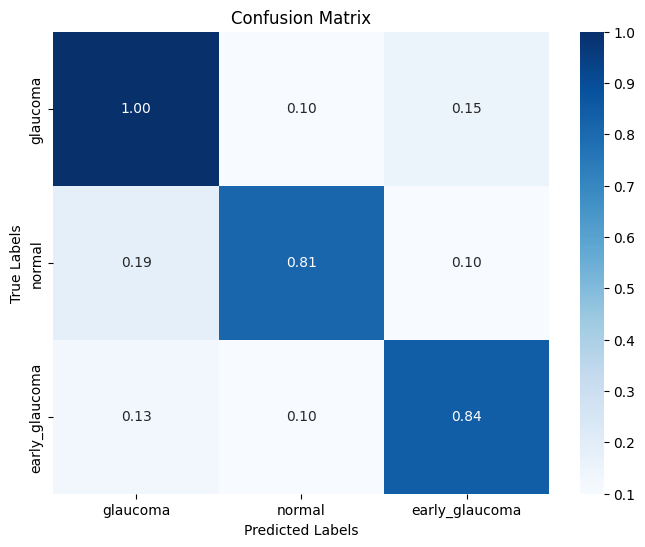

In [ ]:
class_names = list(test_ds.class_indices.keys())  # Assuming test_ds.class_indices contains the mapping of class indices to class names
true_labels = test_ds.classes

report = classification_report(true_labels, final_predictions, target_names=class_names)

print("Classification Report:\n", report)

Classification Report:
                 precision    recall  f1-score   support

      glaucoma       0.30      1.00      0.46        58
        normal       0.74      0.81      0.78       571
early_glaucoma       0.00      0.00      0.00       190

      accuracy                           0.64       819
     macro avg       0.35      0.60      0.41       819
  weighted avg       0.54      0.64      0.57       819



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    # Resize the image to match the model's expected sizing
    img = cv2.resize(img, (224, 224))
    # Expand the dimensions to match the model's expected input shape
    img = np.expand_dims(img, axis=0)
    # Normalize the pixel values to be between 0 and 1
    img = img / 255.0
    return img


In [ ]:
def predict_class(model, image_path):
    # Preprocess the image
    img = preprocess_image(image_path)
    # Make predictions
    predictions = model.predict(img)
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)
    return predicted_class_index


In [ ]:
{'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}

{'glaucoma': 1, 'normal': 0, 'early_glaucoma': 2}

In [ ]:
def get_class_label(predicted_class_index):
    class_labels = [ 'glaucoma','normal','early_glaucoma']
    return class_labels[predicted_class_index]

In [ ]:
image_path = '/content/drive/MyDrive/datasets/real_combined_last_dataset/train/early_glaucoma/232.png'
predicted_index = predict_class(ensemble_model, image_path)
predicted_label = get_class_label(predicted_index)
print(f"The predicted label for the image is: early_glaucoma")

1/1 [==============================] - 0s 19ms/step
The predicted label for the image is: early_glaucoma


In [ ]:
image_path = '/content/drive/MyDrive/datasets/real_combined_last_dataset/test/normal/053.jpg'

predicted_index = predict_class(model_ng, image_path)
predicted_label = get_class_label(predicted_index)
print(f"The predicted label for the image is: {predicted_label}")


1/1 [==============================] - 0s 140ms/step
The predicted label for the image is: normal


In [ ]:
image_path = '/content/drive/MyDrive/datasets/real_combined_last_dataset/test/glaucoma/224.png'

predicted_index = predict_class(ensemble_model, image_path)
predicted_label = get_class_label(predicted_index)
print(f"The predicted label for the image is: {predicted_label}")


1/1 [==============================] - 0s 30ms/step
The predicted label for the image is: glaucoma
